In [1]:
from preproces_books import preprocess_books
#preprocess_books()

In [2]:
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt

In [3]:
usuaris = pd.read_pickle('../../data/casos.pkl')
llibres = pd.read_pickle('../../data/llibres.pkl')

In [6]:
# Dimensiones de los vectores de usuario y libro
dim_usuari = len(usuaris["vector"].iloc[0])
dim_llibre = len(llibres["vector"].iloc[0])
print("Dimensió vector usuari:", dim_usuari)
print("Dimensió vector llibre:", dim_llibre)

# Entradas
entrada_usuari = Input(shape=(dim_usuari,), name='entrada_usuari')
entrada_llibre = Input(shape=(dim_llibre,), name='entrada_llibre')

# Procesamiento de las entradas
proc_usuari = Dense(64, activation='relu')(entrada_usuari)
proc_llibre = Dense(64, activation='relu')(entrada_llibre)

# Combinación de características
combinacio = Concatenate()([proc_usuari, proc_llibre])

# Capas ocultas
oculta1 = Dense(256, activation='relu')(combinacio)
oculta2 = Dense(128, activation='relu')(oculta1)
oculta3 = Dense(64, activation='relu')(oculta2)

# Capa de salida
sortida = Dense(1, activation='linear')(oculta3)

# Creación del modelo
model = Model(inputs=[entrada_usuari, entrada_llibre], outputs=sortida)

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


Dimensió vector usuari: 85
Dimensió vector llibre: 85
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 entrada_usuari (InputLayer  [(None, 85)]                 0         []                            
 )                                                                                                
                                                                                                  
 entrada_llibre (InputLayer  [(None, 85)]                 0         []                            
 )                                                                                                
                                                                                                  
 dense_6 (Dense)             (None, 64)                   5504      ['entrada_usuari[0][0]']      
                                      

In [18]:
def vector_llibre(id_llibre):
    # Pasamos el book_id del libro y devolvemos su vector
    return llibres[llibres["book_id"] == int(id_llibre)]["vector"].iloc[0]

In [19]:
# Inicializa listas vacías para almacenar los datos
vectores_usuarios = []
vectores_libros = []
puntuaciones = []

for user in usuaris.itertuples():
    # Obtiene el vector del usuario
    vector_usuario = user.vector

    # Para cada libro leído y su puntuación
    for book_id, val in zip(user.llibres_usuari, user.val_llibres):
        # Obtiene el vector del libro (modifica esto según tu implementación)
        vector_libro = vector_llibre(book_id)

        # Añade los datos al conjunto de datos
        vectores_usuarios.append(vector_usuario)
        vectores_libros.append(vector_libro)
        puntuaciones.append(val)

    # Repite para los libros recomendados
    for book_id, punt in zip(user.llibres_recomanats, user.puntuacions_llibres):
        # Obtiene el vector del libro (modifica esto según tu implementación)
        vector_libro = vector_llibre(book_id)

        # Añade los datos al conjunto de datos
        vectores_usuarios.append(vector_usuario)
        vectores_libros.append(vector_libro)
        puntuaciones.append(punt)

# Convertir las listas en arrays de NumPy para su uso con TensorFlow/Keras
import numpy as np

vectores_usuarios_np = np.array(vectores_usuarios)
vectores_libros_np = np.array(vectores_libros)
puntuaciones_np = np.array(puntuaciones)

In [20]:
print(vectores_usuarios_np.shape)
print(vectores_libros_np.shape)
print(puntuaciones_np.shape)

(22794, 85)
(22794, 85)
(22794,)


In [21]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    np.hstack((vectores_usuarios_np, vectores_libros_np)),  # Concatenar vectores de usuario y libro
    puntuaciones_np, 
    test_size=0.2, 
    random_state=42
)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18235, 170)
(4559, 170)
(18235,)
(4559,)


In [27]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

# Entrenamiento del modelo
data = [X_train[:, :dim_usuari], X_train[:, dim_usuari:]]
historial = model.fit(
    data,  # Separar los vectores de usuario y libro
    y_train, 
    epochs=10,
    batch_size=8,
    validation_split=0.2
)

Epoch 1/10
1824/1824 [==============================] - 14s 7ms/step - loss: 1.4671 - val_loss: 1.3181
Epoch 2/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.4238 - val_loss: 1.3142
Epoch 3/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.4205 - val_loss: 1.2965
Epoch 4/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.4071 - val_loss: 1.4808
Epoch 5/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.3756 - val_loss: 1.2816
Epoch 6/10
1824/1824 [==============================] - 14s 8ms/step - loss: 1.3605 - val_loss: 1.2989
Epoch 7/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.3362 - val_loss: 1.3127
Epoch 8/10
1824/1824 [==============================] - 14s 7ms/step - loss: 1.3164 - val_loss: 1.3064
Epoch 9/10
1824/1824 [==============================] - 13s 7ms/step - loss: 1.2961 - val_loss: 1.3153
Epoch 10/10
1824/1824 [==============================] - 13s 7ms/step - l

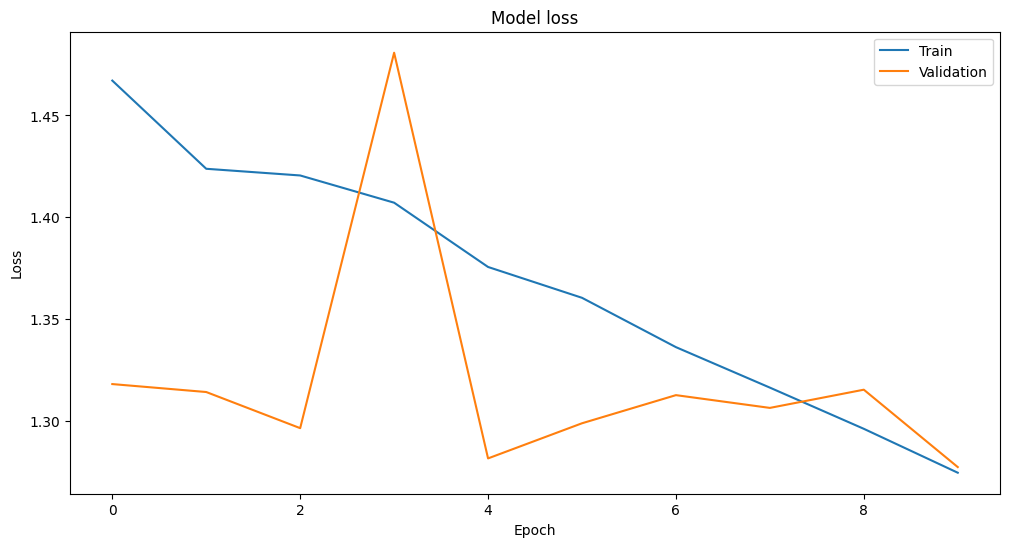

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [30]:
data_eval = [X_test[:, :dim_usuari], X_test[:, dim_usuari:]]
# Evaluación del modelo con el conjunto de prueba
evaluacion = model.evaluate(
    data_eval,
    y_test
)

print(f'Pérdida en el conjunto de prueba: {evaluacion}')

 32/143 [=====>........................] - ETA: 0s - loss: 1.5883

/Users/ucemarc/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


143/143 [==============================] - 0s 3ms/step - loss: 1.4077
Pérdida en el conjunto de prueba: 1.4077028036117554


In [32]:
# Realizar predicciones en el conjunto de prueba
predicciones = model.predict([X_test[:, :dim_usuari], X_test[:, dim_usuari:]])

# Print predictions and actual values
print('Predicciones: ', np.round(predicciones.flatten()[:10],0))
print('Valores reales: ', y_test[:10])

# Definir un umbral de aceptación
umbral = 0.5

# Calcular el número de predicciones "correctas"
predicciones_correctas = np.abs(predicciones.flatten() - y_test) <= umbral

# Calcular la precisión
precision = np.mean(predicciones_correctas)
print(f'Precisión aproximada: {precision * 100:.2f}%')

 52/143 [=========>....................] - ETA: 0s

/Users/ucemarc/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


143/143 [==============================] - 0s 2ms/step
Predicciones:  [5. 2. 4. 4. 5. 4. 4. 3. 4. 4.]
Valores reales:  [4 4 5 5 5 3 5 2 5 4]
Precisión aproximada: 34.06%


In [33]:
# Guardar el modelo completo
model.save('prediccio_puntuacio.keras')